In [1]:
from mimic.utilities.utilities import set_all_seeds
from mimic.utilities.utilities import plot_gLV
from mimic.model_infer import *
from mimic.model_simulate import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint


## Simulate some time course data from the gLV

The generalized Lotka-Volterra equation takes the form

$$ \frac{dX_i}{dt} = \mu_i X_i + X_i M_{ij} X_j + X_i \epsilon_{il} u_l $$

where:
-   $X_i$ is the concentration of a species
-   $\mu_i$ is its specific growth rate
-   $M_{ij}$ is the effect of the interaction of species $i$ on species $j$
-   $\epsilon_{il}$ is the susceptibility to the time-dependent perturbation $u_l$

### Five species, single time course

Model parameters:
Model: gLV
num_species: 5
mu: [1.28 0.56 2.07 0.86 0.7 ]
M: [[-0.05  0.   -0.03  0.    0.  ]
 [ 0.   -0.1   0.    0.05  0.  ]
 [ 0.    0.   -0.15  0.    0.  ]
 [ 0.    0.    0.   -0.01  0.  ]
 [ 0.02  0.    0.    0.   -0.2 ]]
epsilon: []
Using the following parameters for gLV simulation: {'num_species': 5, 'mu': array([1.27853844, 0.55683415, 2.06752757, 0.86387608, 0.70448068]), 'M': array([[-0.05 ,  0.   , -0.025,  0.   ,  0.   ],
       [ 0.   , -0.1  ,  0.   ,  0.05 ,  0.   ],
       [ 0.   ,  0.   , -0.15 ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , -0.01 ,  0.   ],
       [ 0.02 ,  0.   ,  0.   ,  0.   , -0.2  ]]), 'epsilon': array([], shape=(5, 0), dtype=float64)}


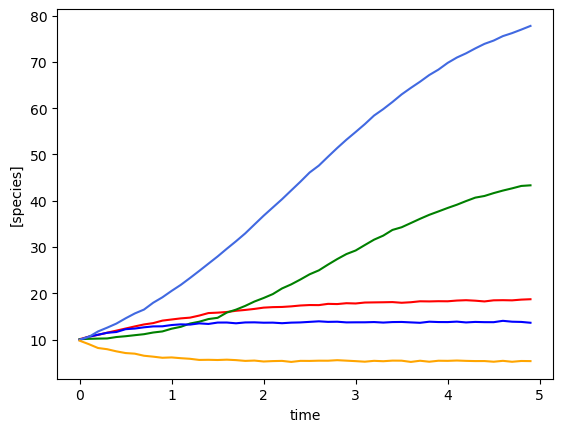

In [2]:
# In this example n >> p and it it is basically same as standard regression
# We have to be careful as most of these gLV models are very weakly identifiable

set_all_seeds(1234)

# SETUP MODEL
# establish size of model
num_species = 5

# construct interaction matrix
# TODO do this programmatically
M = np.zeros((num_species, num_species))
np.fill_diagonal(M, [-0.05, -0.1, -0.15, -0.01, -0.2])
M[0, 2] = -0.025
M[1, 3] = 0.05
M[4, 0] = 0.02

# construct growth rates matrix
mu = np.random.lognormal(0.01, 0.5, num_species)

# instantiate simulator
simulator = sim_gLV(num_species=num_species,
                    M=M,
                    mu=mu)
simulator.print_parameters()

# PRODUCE SIMULATED RESULTS
# initial conditions
init_species = 10 * np.ones(num_species)

times = np.arange(0, 5, 0.1)
yobs, init_species, mu, M, _  = simulator.simulate(times=times, init_species=init_species)

# add some gaussian noise
yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)

# plot simulation
plot_gLV(yobs, times)

### Same model but now include a single perturbation

Model parameters:
Model: gLV
num_species: 5
mu: [1.28 0.56 2.07 0.86 0.7 ]
M: [[-0.05  0.   -0.03  0.    0.  ]
 [ 0.   -0.1   0.    0.05  0.  ]
 [ 0.    0.   -0.15  0.    0.  ]
 [ 0.    0.    0.   -0.01  0.  ]
 [ 0.02  0.    0.    0.   -0.2 ]]
epsilon: [[ 0.]
 [-1.]
 [ 0.]
 [-1.]
 [ 0.]]
Using the following parameters for gLV simulation: {'num_species': 5, 'mu': array([1.27853844, 0.55683415, 2.06752757, 0.86387608, 0.70448068]), 'M': array([[-0.05 ,  0.   , -0.025,  0.   ,  0.   ],
       [ 0.   , -0.1  ,  0.   ,  0.05 ,  0.   ],
       [ 0.   ,  0.   , -0.15 ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , -0.01 ,  0.   ],
       [ 0.02 ,  0.   ,  0.   ,  0.   , -0.2  ]]), 'epsilon': array([[ 0.],
       [-1.],
       [ 0.],
       [-1.],
       [ 0.]])}


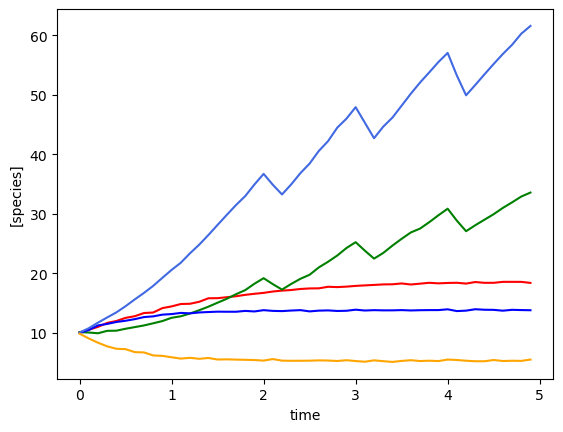

In [9]:
# construct perturbation matrix
npert = 1
epsilon = np.zeros([num_species, npert])
epsilon[:, 0] = [0, -1, 0, -1, 0]

simulator = sim_gLV(num_species=num_species,
                     num_perturbations=npert,
                     M=M,
                     mu=mu,
                     epsilon=epsilon)
simulator.print_parameters()

# perturbation information encoded in a function
#def pert_fn(t):
#    return np.array([1]) if 2.0 <= t < 2.2 else np.array([0])

# create a perturbation function including a perturbation at t=2, t=3 and t=4
def pert_fn(t):
    if 2.0 <= t < 2.2 or 3.0 <= t < 3.2 or 4.0 <= t < 4.2:
        return np.array([1])
    else: 
        return np.array([0])

times = np.arange(0, 5, 0.1)
yobs, init_species, mu, M, _  = simulator.simulate(times=times, init_species=init_species, u=pert_fn)

# add some gaussian noise
yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)

# plot simulation
plot_gLV(yobs, times)
